In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image                  
from tqdm import tqdm
from PIL import ImageFile

from tensorflow.contrib.cloud.python.ops.bigquery_reader_ops import *



AttributeError: module 'tensorflow.python.framework.op_def_registry' has no attribute 'register_op_list'

In [6]:
# function for loading datasets
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 10)
    return files, targets

# loading train, test, and validation datasets
train_files, train_targets = load_dataset('state-farm-distracted-driver-detection/imgs/train')
test_files, test_targets = load_dataset('state-farm-distracted-driver-detection/imgs/test')


# load list of names
names = [item[17:19] for item in sorted(glob("state-farm-distracted-driver-detection/imgs/train/*/"))]

# break training set into training and validation sets
train_files, valid_files, train_targets, valid_targets = train_test_split(train_files, train_targets, test_size=0.2, random_state=42)

# statistics regarding dataset
print('There are %s total images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training images.' % len(train_files))
print('There are %d total training categories.' % len(names))
print('There are %d validation images.' % len(valid_files))
print('There are %d test images.'% len(test_files))

There are 22424 total images.

There are 17939 training images.
There are 10 total training categories.
There are 4485 validation images.
There are 0 test images.


In [8]:
df = pd.read_csv("state-farm-distracted-driver-detection/driver_imgs_list.csv",header='infer')
print(df['classname'].head(100))
print(df.iloc[:,1].describe())
print("\nlabel   #")
print(df['classname'].value_counts(sort=False))

0     c0
1     c0
2     c0
3     c0
4     c0
      ..
95    c1
96    c1
97    c1
98    c1
99    c1
Name: classname, Length: 100, dtype: object
count     22424
unique       10
top          c0
freq       2489
Name: classname, dtype: object

label   #
c9    2129
c3    2346
c4    2326
c7    2002
c2    2317
c1    2267
c0    2489
c8    1911
c5    2312
c6    2325
Name: classname, dtype: int64


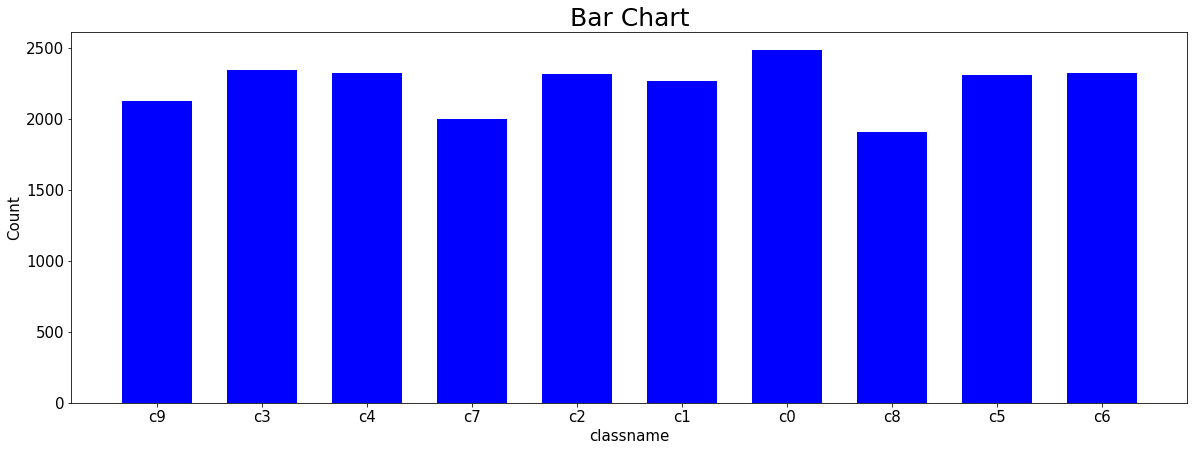

In [9]:
%matplotlib inline

nf = df['classname'].value_counts(sort=False)
labels = df['classname'].value_counts(sort=False).index.tolist()
y = np.array(nf)
width = 1/1.5
N = len(y)
x = range(N)

fig = plt.figure(figsize=(20,15))
ay = fig.add_subplot(211)

plt.xticks(x, labels, size=15)
plt.yticks(size=15)

ay.bar(x, y, width, color="blue")

plt.title('Bar Chart',size=25)
plt.xlabel('classname',size=15)
plt.ylabel('Count',size=15)

plt.show()

In [10]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [11]:
# rescaling images by dividing every pixel in every image by 255. 
# subtract 0.5 to ensure the mean is zero
                     
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255 - 0.5
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255 - 0.5
test_tensors = paths_to_tensor(test_files).astype('float32')/255 - 0.5

100%|██████████| 4485/4485 [00:30<00:00, 148.34it/s]
0it [00:00, ?it/s]


ValueError: need at least one array to concatenate

In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# visulization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import gc # garbage collection
import glob # extract path via pattern matching
import random
import math
import cv2 # read image
# store to disk
import pickle
import h5py # like numpy array


from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from keras.models import Sequential, Model
from keras.models import load_model
from keras.layers import Input, Dense, Conv2D, MaxPool2D, AveragePooling2D
from keras.layers import Flatten, Dropout, BatchNormalization, Activation
from keras.layers import Add
from keras.optimizers import SGD, RMSprop, Adam
from keras import regularizers
import keras

from keras.callbacks import ModelCheckpoint, EarlyStopping

In [16]:
ROOT_DIR = '../cs747-project/' #change the path
TRAIN_DIR = ROOT_DIR + 'state-farm-distracted-driver-detection/imgs/train/'
TEST_DIR = ROOT_DIR + 'state-farm-distracted-driver-detection/imgs/test/'
driver_imgs_list = pd.read_csv(ROOT_DIR + "state-farm-distracted-driver-detection/" + "driver_imgs_list.csv")
sample_submission = pd.read_csv(ROOT_DIR + "state-farm-distracted-driver-detection/" + "sample_submission.csv")

In [17]:
def get_image(path, img_height=None, img_width=None, rotate=False, color_type=0):
    img = cv2.imread(path, color_type)
    if img_width and img_height:
        img = cv2.resize(img, (img_width, img_height))
    if rotate is True:
        rows, cols = img.shape
        rotation_angle = random.uniform(10,-10)
        M = cv2.getRotationMatrix2D((cols/2, rows/2), rotation_angle, 1)
        img = cv2.warpAffine(img, M, (cols,rows))
    return img

In [18]:
random_list = np.random.permutation(len(driver_imgs_list))[:50]
df_copy = driver_imgs_list.iloc[random_list]
image_paths = [TRAIN_DIR+row.classname+'/'+row.img 
                   for (index, row) in df_copy.iterrows()]
image_shapes = [get_image(path).shape for path in image_paths]
print(set(image_shapes))

{(480, 640)}


In [19]:
img_path_list = []
label_list = []
for index, row in driver_imgs_list.iterrows():
    img_path_list.append('{0}{1}/{2}'.format(TRAIN_DIR, row.classname, row.img))
    label_list.append(int(row.classname[1]))
# One hot vector representation of labels
y_labels_one_hot = to_categorical(label_list, dtype=np.int8)
x_img_path = np.array(img_path_list)

In [20]:
from sklearn.utils import shuffle

np.save('x_img_path.npy', x_img_path)
np.save('y_labels_one_hot.npy', y_labels_one_hot)

x_img_path_shuffled, y_labels_one_hot_shuffled = shuffle(x_img_path, y_labels_one_hot)

# saving the shuffled file.
# you can load them later using np.load().
np.save('y_labels_one_hot_shuffled.npy', y_labels_one_hot_shuffled)
np.save('x_img_path_shuffled.npy', x_img_path_shuffled)

In [21]:
from sklearn.model_selection import train_test_split
# Used this line as our filename array is not a numpy array.
x_img_path_shuffled_numpy = np.array(x_img_path_shuffled)

X_train_filenames, X_val_filenames, y_train, y_val = train_test_split(
    x_img_path_shuffled_numpy, y_labels_one_hot_shuffled, test_size=0.2, random_state=1)

print(X_train_filenames.shape) # (3800,)
print(y_train.shape)           # (3800, 12)

print(X_val_filenames.shape)   # (950,)
print(y_val.shape)             # (950, 12)

# You can save these files as well. As you will be using them later for training and validation of your model.
np.save('X_train_filenames.npy', X_train_filenames)
np.save('y_train.npy', y_train)

np.save('X_val_filenames.npy', X_val_filenames)
np.save('y_val.npy', y_val)

(17939,)
(17939, 10)
(4485,)
(4485, 10)


In [22]:
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 32
CHANNEL = 3
class Img_Generator(keras.utils.Sequence):
    def __init__(self, image_filenames, labels, batch_size) :
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        img_list = []
        for file_name in batch_x:
            if CHANNEL == 1:
                original_img = cv2.imread(file_name, 0)
            else:
                original_img = cv2.imread(file_name, 1)
            im = cv2.resize(original_img, (IMG_HEIGHT, IMG_WIDTH))
            #color = [0, 0, 0]
            #new_im = cv2.copyMakeBorder(im, 40, 40, 0, 0, cv2.BORDER_CONSTANT, value=color)
            #im = cv2.resize(new_im, (224, 224))
            img_list.append(im)
        img_batch = np.array(img_list)
        if CHANNEL == 1:
            img_batch = np.expand_dims(img_batch, axis=-1)
        return img_batch, np.array(batch_y)

In [23]:
# size of input [BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, CHANNEL]
train_gen = Img_Generator(X_train_filenames, y_train, BATCH_SIZE)
val_gen = Img_Generator(X_val_filenames, y_val, BATCH_SIZE)

In [24]:
!rm -f saved_models/weights_best_efficient.hdf5

In [25]:
import ssl
from efficientnet.keras import EfficientNetB5
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D,concatenate,Concatenate,multiply, LocallyConnected2D, Lambda)

nb_train_samples = 17943
nb_validation_samples = 4481

IMAGENET_WEIGHTS_HASHES = {
    'efficientnet-b5': ('30172f1d45f9b8a41352d4219bf930ee'
                        '3339025fd26ab314a817ba8918fefc7d',
                        '9d197bc2bfe29165c10a2af8c2ebc675'
                        '07f5d70456f09e584c71b822941b1952')
}
IMAGENET_WEIGHTS_PATH = (
    'https://github.com/Callidior/keras-applications/'
    'releases/download/efficientnet/')

eff_net = EfficientNetB5(weights= None, include_top=False, input_shape=(64, 64, 3))
in_lay = Input(shape=(64,64,3))

file_name = "efficientnet-b5" + '_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5'
file_hash = IMAGENET_WEIGHTS_HASHES["efficientnet-b5"][1]
weights_path = keras.utils.get_file(
            file_name,
            IMAGENET_WEIGHTS_PATH + file_name,
            cache_subdir='models',
            file_hash=file_hash,
 )
eff_net.load_weights(weights_path)
pt_depth = eff_net.get_output_shape_at(0)[-1]
pt_features = eff_net(in_lay)
bn_features = BatchNormalization()(pt_features)


AttributeError: module 'tensorflow.python.framework.ops' has no attribute '_TensorLike'

In [ ]:
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D,concatenate,Concatenate,multiply, LocallyConnected2D, Lambda)
# here we do an attention mechanism to turn pixels in the GAP on an off
attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid')(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(10, activation = 'softmax')(dr_steps)
retina_model = Model(inputs = [in_lay], outputs = [out_layer])
